In [ ]:
import torch
import datasets
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import numpy as np
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import distance


In [ ]:
dataset = datasets.load_dataset("huggingartists/egor-letov")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.21k [00:00<?, ?B/s]

egor-letov.py:   0%|          | 0.00/4.08k [00:00<?, ?B/s]

default/train/0000.parquet:   0%|          | 0.00/266k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/543 [00:00<?, ? examples/s]

In [ ]:
nltk.download('stopwords')
ss = SnowballStemmer('russian')
sw = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def split_tokens(row):
    row['all_tokens'] = [ss.stem(i) for i in
                     re.split(r" +",
                    re.sub(r"[^а-я@# ]", "",
                            row['text'].lower()))
                     if (i not in sw) and len(i)]
    return row

dataset = dataset.map(split_tokens)

Map:   0%|          | 0/543 [00:00<?, ? examples/s]

In [ ]:
counts = Counter([i for s in dataset['train']['all_tokens'] for i in s])
counts = {k:v for k, v in counts.items() if v > 10}
vocab = list(counts.keys())
n_v = len(vocab)
id2tok = dict(enumerate(vocab))
tok2id = {token: id for id, token in id2tok.items()}

In [ ]:
def remove_rare_tokens(row):
    row['tokens'] = [t for t in row['all_tokens'] if t in vocab]
    return row

dataset = dataset.map(remove_rare_tokens)

Map:   0%|          | 0/543 [00:00<?, ? examples/s]

In [ ]:
def bow(row):
    vector = np.zeros(len(id2tok))
    for v in row['tokens']:
        k = tok2id[v]
        vector[k] += 1
    row['vector'] = vector
    return row

dataset = dataset.map(bow)

Map:   0%|          | 0/543 [00:00<?, ? examples/s]

In [ ]:
def windowizer(row, wsize=3):
    doc = row['tokens']
    out = []
    for i, wd in enumerate(doc):
        target = tok2id[wd]
        window = [i + j for j in range(-wsize, wsize + 1) if (i + j >= 0) & (i + j < len(doc)) & (j != 0)]
        out += [(target, tok2id[doc[w]]) for w in window]
    row['moving_window'] = out
    return row

dataset = dataset.map(windowizer)

Map:   0%|          | 0/543 [00:00<?, ? examples/s]

In [ ]:
class Word2VecDataset(Dataset):
    def __init__(self, dataset, vocab_size):
        self.data = [i for s in dataset['moving_window'] for i in s]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

BATCH_SIZE = 2**14

dataloader = {}
for key in dataset.keys():
    dataloader[key] = DataLoader(Word2VecDataset(dataset[key], vocab_size=n_v),
                                 batch_size=BATCH_SIZE,
                                 shuffle=True)

In [ ]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        hidden = self.embed(input)
        logits = self.expand(hidden)
        return logits

EMBED_SIZE = 100
model = Word2Vec(n_v, EMBED_SIZE)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

LR = 3e-4
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

 98%|█████████▊| 39/40 [00:05<00:00,  7.53it/s]

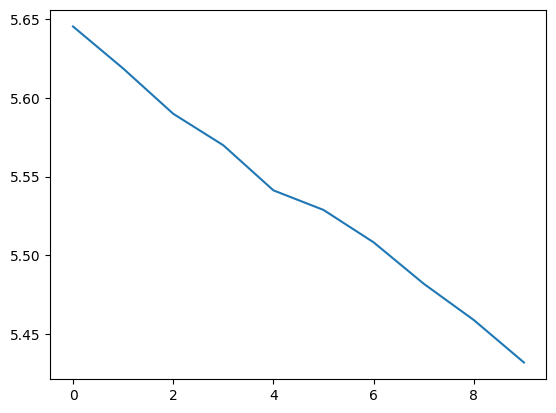

In [ ]:
progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
running_loss = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = model(context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)

plt.plot(running_loss)

In [ ]:
wordvecs = model.expand.weight.cpu().detach().numpy()

In [ ]:
def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    if word not in tok2id:
        print(f"Слово '{word}' отсутствует в словаре.")
        return
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k + 1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')

In [ ]:
example_words = ['нам', 'всем', 'мир']
for word in example_words:
    similar_words = get_k_similar_words(word, dmat)
    print(word, [t[1] for t in similar_words])

нам ['больш', 'пыла', 'б', 'пойма', 'соб', 'женщин', 'наш', 'бинт', 'стоюурбанизмдетерминизм', 'котор']
всем ['ищ', 'свеж', 'пул', 'бля', 'жизньотнын', 'вмест', 'проверк', 'соб', 'гдет', 'нов']
мир ['дада', 'упа', 'давн', 'пахнетв', 'вообщ', 'ктот', 'люб', 'двер', 'стран', 'сегодн']


In [ ]:
MODEL_SAVE_PATH = "word2vec_model.pth"
torch.save(model.state_dict(), MODEL_SAVE_PATH)